#**Deep Learning Project** 
## Question 3 - Part 1
### *Tranfer Learning from CIFAR100 Dataset Using DCGAN to Food101 Dataset*

In [0]:
####### Importing the library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import svm
from torch.autograd import Variable
from itertools import groupby
from random import sample

# setting the seed for same sample and results
torch.manual_seed(1)
np.random.seed(1)

In [0]:
########### Setting the Environment
print("Cuda Available - ",torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

# set device to cuda, if gpu is available
if torch.cuda.is_available():
    aDev = torch.device("cuda")
else:
    aDev = torch.device("cpu") 

batch_size = 100 # Batch size during training
image_size = 32 # Spatial size of training images. All images will be resized to this size using a transformer.
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 50 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
feature_file = 'dataset_location/models/feature.txt' # File to save the features

Cuda Available -  True


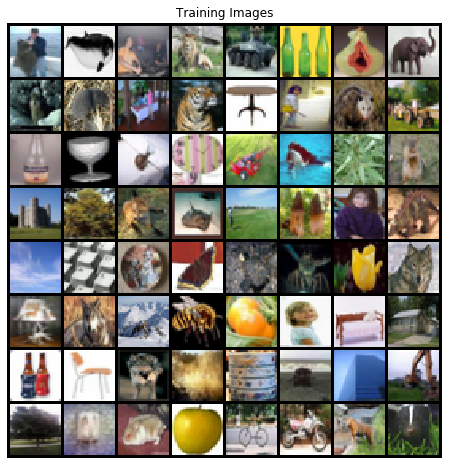

In [0]:
# loading the CIFAR100 dataset directly from torchvision datasets    
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_cifar = dsets.CIFAR100(root='dataset_location/CIFAR100_Data/',
                            train=True,
                            transform=train_transforms,
                            download=True)

# make the dataset iterable
train_loader_cifar = torch.utils.data.DataLoader(dataset=train_dataset_cifar,
                                           batch_size=batch_size,
                                           shuffle=True)

# Plot some training images
real_batch = next(iter(train_loader_cifar))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(aDev)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
# all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # change here as our images are in 32 * 32 pixel dimension
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator().to(aDev)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [0]:
# Discriminator Code
# Updated to save the features
class Discriminator(nn.Module):
  def __init__(self, ndf=64, nc=3):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Sequential( 
						nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
						nn.LeakyReLU(0.2, inplace=True)
						)
    self.conv2 = nn.Sequential(
						nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
						nn.BatchNorm2d(ndf * 2),
						nn.LeakyReLU(0.2, inplace=True)
						)

    self.conv3 = nn.Sequential(
						nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
						nn.BatchNorm2d(ndf * 4),
						nn.LeakyReLU(0.2, inplace=True)
						)

    self.conv4 = nn.Sequential(
						nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
						nn.BatchNorm2d(ndf * 8),
						nn.LeakyReLU(0.2, inplace=True)
						)

    self.conv5 = nn.Sequential(
			nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
			nn.Sigmoid()
			)

  def forward(self, x):
    out = self.conv5(self.conv4(self.conv3(self.conv2(self.conv1(x)))))
    return out.view(-1, 1).squeeze(1)

  def get_conv_features(self, x):
   features1 = self.conv1(x)
   features2 = self.conv2(features1)
   features3 = self.conv3(features2)
   features4 = self.conv4(features3)
   pool_ = nn.MaxPool2d(int(features4.size(2) / 2))
   features4 = pool_(features4)
   feature_vec = features4.view(x.size(0), -1).squeeze(1)
   return feature_vec

# Create the Discriminator
netD = Discriminator().to(aDev)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512,

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(32, nz, 1, 1, device=aDev)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
####################### Training Loop
# tracking time for the model to run 
%%time 

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    #print(epoch)
    # For each batch in the dataloader
    for i, data in enumerate(train_loader_cifar, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        # print(data[0].shape)
        real_cpu = data[0].to(aDev)
        b_size = real_cpu.size(0)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        label = torch.full((b_size,), real_label, device=aDev)
        #print(output.shape)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=aDev)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader_cifar),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader_cifar)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# Saving the network for training for future use
torch.save(netG.state_dict(), 'dataset_location/models/generator.pth')
torch.save(netD.state_dict(), 'dataset_location/models/discriminator.pth')

Starting Training Loop...
[1/50][0/500]	Loss_D: 1.4567	Loss_G: 1.5734	D(x): 0.4378	D(G(z)): 0.4270 / 0.2173
[1/50][50/500]	Loss_D: 0.5086	Loss_G: 7.2840	D(x): 0.8198	D(G(z)): 0.2116 / 0.0013
[1/50][100/500]	Loss_D: 0.7812	Loss_G: 2.6123	D(x): 0.7642	D(G(z)): 0.3573 / 0.0899
[1/50][150/500]	Loss_D: 0.8342	Loss_G: 3.9549	D(x): 0.8599	D(G(z)): 0.4540 / 0.0240
[1/50][200/500]	Loss_D: 0.8517	Loss_G: 2.4942	D(x): 0.5101	D(G(z)): 0.0917 / 0.1009
[1/50][250/500]	Loss_D: 0.3903	Loss_G: 2.4245	D(x): 0.8281	D(G(z)): 0.1716 / 0.0987
[1/50][300/500]	Loss_D: 1.0634	Loss_G: 3.1986	D(x): 0.6265	D(G(z)): 0.2984 / 0.0642
[1/50][350/500]	Loss_D: 1.0497	Loss_G: 3.8232	D(x): 0.7441	D(G(z)): 0.4799 / 0.0303
[1/50][400/500]	Loss_D: 0.6792	Loss_G: 2.2356	D(x): 0.7249	D(G(z)): 0.2652 / 0.1243
[1/50][450/500]	Loss_D: 0.5046	Loss_G: 3.4830	D(x): 0.8007	D(G(z)): 0.2122 / 0.0399
[2/50][0/500]	Loss_D: 1.0379	Loss_G: 3.9577	D(x): 0.7539	D(G(z)): 0.4942 / 0.0264
[2/50][50/500]	Loss_D: 1.2702	Loss_G: 2.8123	D(x): 0.65

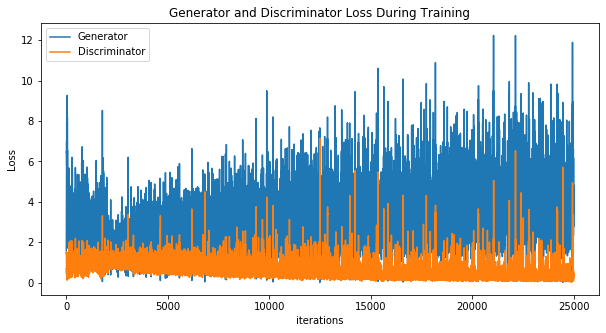

In [0]:
############ Plotting the Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

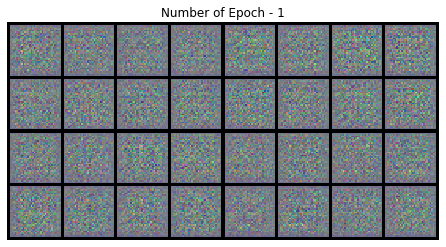

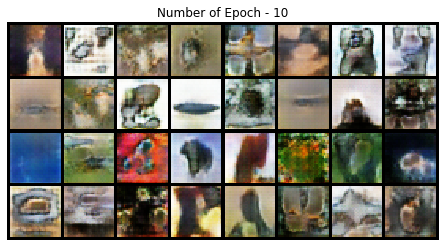

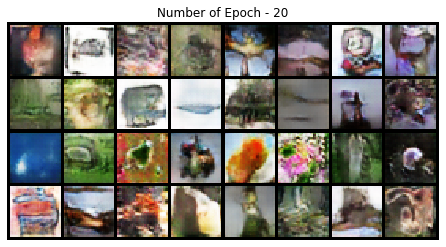

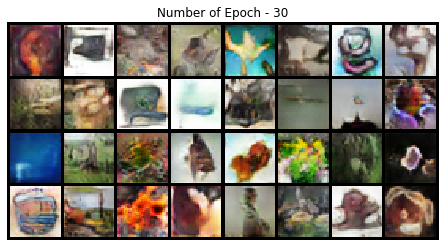

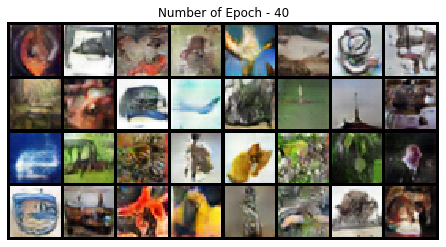

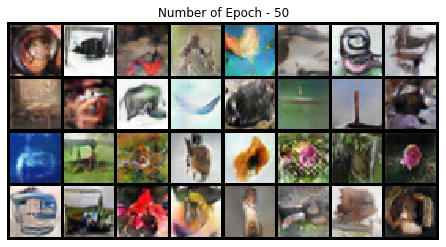

In [0]:
# Plot the model learning after every epoch for all the epochs
plt.figure(figsize=(8,4))
plt.title('Number of Epoch - 1')
plt.imshow(np.transpose(img_list[0],(1,2,0))) 
plt.axis("off")
plt.show()  
      
plt.figure(figsize=(8,4))
plt.title('Number of Epoch - 10')
plt.imshow(np.transpose(img_list[9],(1,2,0))) 
plt.axis("off")
plt.show()  

plt.figure(figsize=(8,4))
plt.title('Number of Epoch - 20')
plt.imshow(np.transpose(img_list[19],(1,2,0))) 
plt.axis("off")
plt.show()  

plt.figure(figsize=(8,4))
plt.title('Number of Epoch - 30')
plt.imshow(np.transpose(img_list[29],(1,2,0))) 
plt.axis("off")
plt.show()  

plt.figure(figsize=(8,4))
plt.title('Number of Epoch - 40')
plt.imshow(np.transpose(img_list[39],(1,2,0))) 
plt.axis("off")
plt.show()  

plt.figure(figsize=(8,4))
plt.title('Number of Epoch - 50')
plt.imshow(np.transpose(img_list[49],(1,2,0))) 
plt.axis("off")
plt.show()  


In [0]:
## Unzipping the tar file for Food101 dataset will take approximately 23 mins
#%%time
#import tarfile
#my_tar = tarfile.open('dataset_location/food-101.tar.gz')
#my_tar.extractall('dataset_location')
#my_tar.close()

CPU times: user 1min 28s, sys: 58.8 s, total: 2min 27s
Wall time: 23min 51s


In [0]:
# Making the food101 dataset similar to our CIFAR100 dataset with same transformation
%%time

# shortening the dataset
train_dataset_food= dsets.ImageFolder(root='dataset_location',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
train_loader_food = torch.utils.data.DataLoader(dataset=train_dataset_food,
                                          batch_size=batch_size,
                                           shuffle=True)
print(len(train_dataset_food))

30300
CPU times: user 125 ms, sys: 11.1 ms, total: 136 ms
Wall time: 630 ms


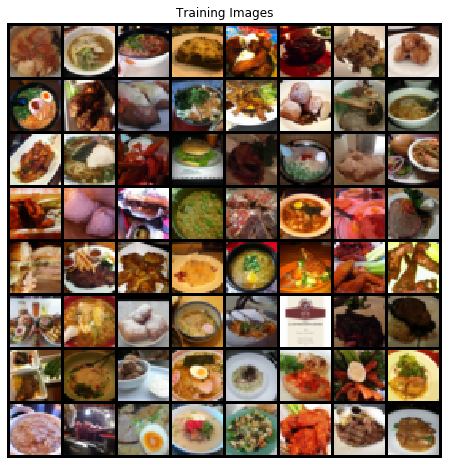

In [0]:
# Plot some training images
real_batch = next(iter(train_loader_food))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(aDev)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
### Function to save the features
def save_features(dataloader, batch_size, n_features):
    features_ = np.zeros([len(dataloader), batch_size, n_features])
    labels_ = np.zeros([len(dataloader), batch_size])
    
    for b_idx, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.cuda()
        features = netD.get_conv_features(imgs)
        print(b_idx)
        features_[b_idx,:,:] = features.detach().cpu().numpy()
        labels_[b_idx,: ] = labels.detach().cpu().numpy()

    shape = features_.shape
    features_ = features_.reshape(shape[0]*shape[1], shape[2])
    labels_ = labels_.reshape(shape[0]*shape[1])
    feature_mat = np.concatenate((features_, labels_[:, np.newaxis]), axis=1).astype(np.float16)
    np.savetxt(feature_file, feature_mat)
    return feature_mat

In [0]:
netD.load_state_dict(torch.load('dataset_location/models/discriminator.pth'))
print(netD)
netD.eval()
n_features = 2048 #512x2x2

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512,

In [0]:
### Getting the features for the food dataset
%%time
extract_feat = save_features(train_loader_food, batch_size, n_features)
print(extract_feat.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
#extract_feat = np.loadtxt(feature_file,dtype=np.float16)
### Dividing the dataset into test and train
features, labels = extract_feat[:, : -1], extract_feat[:, -1: ]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=13)
y_train = np.ravel(y_train).astype(int)
y_test = np.ravel(y_test).astype(int)
print("Training Size",len(X_train))
print("Training Size",len(X_test))

Training Size 24240
Training Size 6060


In [0]:
### Creating the svm model for multi class as we have 101 classes
clf = svm.SVC(decision_function_shape='ovo')

In [0]:
### fitting the model to training data  
%%time
clf.fit(X_train, y_train)

CPU times: user 36min 57s, sys: 433 ms, total: 36min 57s
Wall time: 37min 2s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
### Predicting and reporting the result
predict_labels = clf.predict(X_test)
print(classification_report(y_test, predict_labels))

              precision    recall  f1-score   support

           0       0.03      0.02      0.02        58
           1       0.12      0.15      0.13        61
           2       0.15      0.08      0.11        62
           3       0.31      0.23      0.26        57
           4       0.07      0.07      0.07        54
           5       0.22      0.22      0.22        60
           6       0.20      0.27      0.23        63
           7       0.30      0.38      0.33        61
           8       0.03      0.04      0.03        51
           9       0.14      0.07      0.09        57
          10       0.03      0.02      0.02        56
          11       0.16      0.34      0.21        64
          12       0.16      0.22      0.18        55
          13       0.13      0.16      0.14        51
          14       0.15      0.11      0.13        53
          15       0.00      0.00      0.00        63
          16       0.09      0.15      0.11        62
          17       0.11    

# References



*   https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
*   https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
